# CNN Image Classifier

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import os

2025-04-10 22:03:27.913856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744344207.928201  277431 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744344207.932524  277431 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744344207.944684  277431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744344207.944705  277431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744344207.944708  277431 computation_placer.cc:177] computation placer alr

## Hyperparameters

In [2]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
EPOCHS = 100

## Dataset

The used [Animal Image Dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals). It was split into a training and testing set at an 80 to 20 ratio using [this script](./split.ipynb)

In [3]:
dataset_dir = os.path.join('datasets', 'animals')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

We build the image loaders. For training we also apply data augmentation through rotation, width shifting, zoom in and horizontal flipping. The images are also rescaled so taht the pixel values are between 0 and 1 instead of 0 to 255

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode="binary",
)

classes = len(train_generator.class_indices)

Found 4320 images belonging to 90 classes.


## Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    BatchNormalization, 
)
from tensorflow.keras.applications.vgg16 import VGG16

model = Sequential()

vgg16_layer = VGG16(weights="imagenet", include_top=False)
vgg16_layer.trainable = False

model.add(Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(vgg16_layer)
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(classes, activation="softmax"))

model.summary()

I0000 00:00:1744344210.178823  277431 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 90)             │       368,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,423,258 (249.57 MB)

 Trainable params: 50,708,570 (193.44 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
)

In [7]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "checkpoints/animal_model_2_{epoch:02d}.keras",
        save_freq=len(train_generator) * 5, # every 5 epochs
    ),
]

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
)

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1744344212.663112  277634 service.cc:152] XLA service 0x79306c006ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744344212.663135  277634 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-10 22:03:32.689005: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744344213.157302  277634 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-10 22:03:33.867242: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1463', 32 bytes spill stores, 32 bytes spill loads

2025-04-10 22:03:33.909432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusio

  1/135 ━━━━━━━━━━━━━━━━━━━━ 15:41 7s/step - accuracy: 0.0000e+00 - loss: 4.6447

I0000 00:00:1744344218.499403  277634 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.0129 - loss: 4.6948
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.0262 - loss: 4.4728
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.0561 - loss: 4.2929
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.1020 - loss: 4.1061
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.1167 - loss: 3.9456
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.1611 - loss: 3.7523
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.1982 - loss: 3.5367
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.2215 - loss: 3.3803
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - accuracy: 0.2612 - loss: 3.1902
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step - accuracy: 0.2996 - loss: 2.9881
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.3232 - loss: 2.8736
Epoch 12/100
135/135

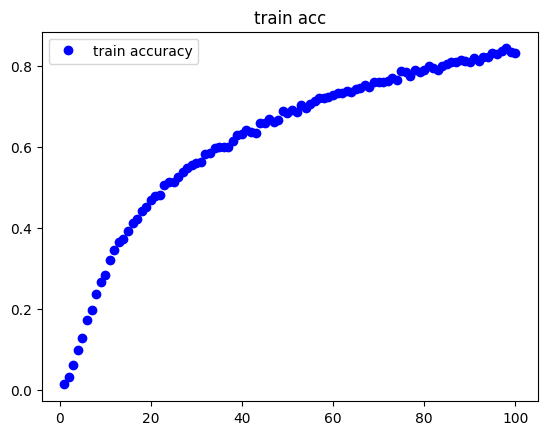

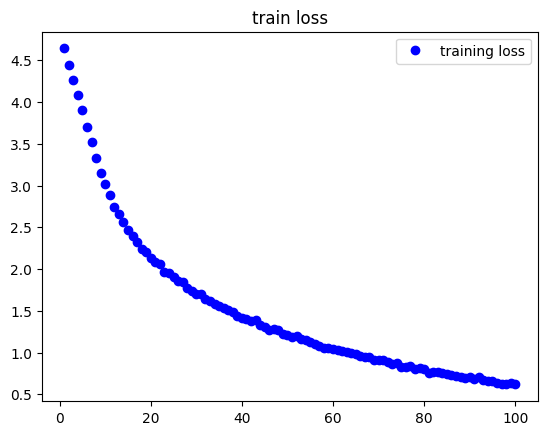

In [10]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [11]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

Found 1080 images belonging to 90 classes.


2025-04-11 07:08:52.372430: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194_0', 48 bytes spill stores, 48 bytes spill loads

2025-04-11 07:08:52.649204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 488 bytes spill stores, 488 bytes spill loads

2025-04-11 07:08:52.695948: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 820 bytes spill stores, 820 bytes spill loads

2025-04-11 07:08:53.070778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 64 bytes spill stores, 64 bytes spill loads

2025-04-11 07:08:53.105993: I external

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6617 - loss: 1.3178

2025-04-11 07:08:58.086911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 07:08:58.229161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194_0', 36 bytes spill stores, 36 bytes spill loads

2025-04-11 07:08:58.594201: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 476 bytes spill stores, 476 bytes spill loads

2025-04-11 07:08:58.678145: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 532 bytes spill stores, 532 bytes spill loads

2025-04-11 07:08:58.826419: I external/l

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.6628 - loss: 1.3127
Test accuracy: 0.6805555820465088
Test loss: 1.228549838066101
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step


Classification Report:
                precision    recall  f1-score   support

      antelope       0.64      0.58      0.61        12
        badger       1.00      0.42      0.59        12
           bat       0.58      0.58      0.58        12
          bear       0.50      0.67      0.57        12
           bee       0.55      0.92      0.69        12
        beetle       0.71      0.83      0.77        12
         bison       0.40      0.17      0.24        12
          boar       0.30      0.58      0.40        12
     butterfly       0.79      0.92      0.85        12
           cat       0.82      0.75      0.78        12
   caterpillar       0.58      0.58      0.58        12
    chimpanzee       0.75      0.50      0.60        12
     cockroach       0.82      0.75      0.78        12
           cow       0.53      0.67      0.59        12
        coyote       0.62      0.42      0.50        12
          crab       0.89      0.67      0.76        12
          crow       0.8

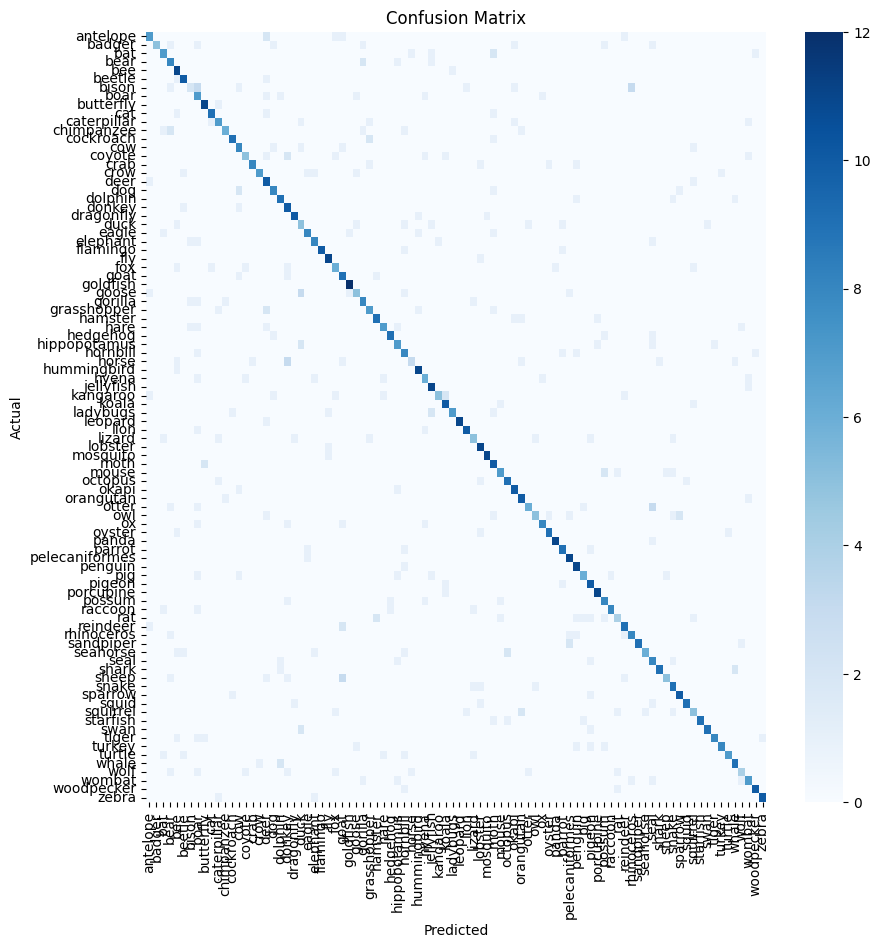

In [12]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
)


conf_matrix = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(report)

plt.figure(figsize=(10, 10))
sns.heatmap(
    conf_matrix,
    # annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    # xtickrotation=45,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
